In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [1]:
%time
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
# output workaround, sometimes necessary
#import matplotlib
#matplotlib.use('Agg')
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
from eden.graph import Vectorizer
import matplotlib.pyplot as plt
import itertools
from eden.util import fit, random_bipartition_iter , fit_estimator
from sklearn.linear_model import SGDClassifier
import random


# a vectorizer
vectorizer = Vectorizer( complexity=3 )

# select 1st element in an iterator
def unpack(graphs):
    for graphlist in graphs:
        yield graphlist[0]

# positive set contains 2401 elements, of which we use 30% to test of we cen improve them ,
# the rest is used for the oracle
lenpo=int(2401*.3)


sampler_graph,oracle = random_bipartition_iter(gspan_to_eden('bursi.pos.gspan'),.3)

# we create an oracle
#estimator=make_estimator(oracle,gspan_to_eden('bursi.neg.gspan'))
X=vectorizer.transform(oracle)
X_=X.multiply(-1)
estimator= fit_estimator(SGDClassifier(),X,X_)
print 'estimator ok'


CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 5.96 µs
estimator ok


In [2]:
%%time
import numpy as np

# ok we create an iterator over the graphs we want to work with... 
graphs_pos= sampler_graph

# save results here:
originals=[]
samples=[]

# we want to use an increasing part of the test set.. 
percentages=[.01, .05, .12, .25, .5 ,1 ]
percentages=[0.1, 0.2, 0.3, 0.4]

sampler = GraphLearnSampler()

for perc in percentages:
    
    # we work with count many graphs
    count = int(lenpo*perc)
    # make copy of graphiterator
    # select count random elements
    # triplicate  the count long iterator
    graphs_pos, graphs_pos_ = itertools.tee(graphs_pos)
  
    # i pick only perc many :) 
    graphs_pos_,zzz = random_bipartition_iter(graphs_pos_, perc )    
    graphs_pos_,graphs_pos__,graphs_pos___ = itertools.tee(graphs_pos_,3)

    # do sampling
    sampler.fit(graphs_pos__,n_jobs=4)

    improved_graphs = sampler.sample( graphs_pos_,
                        same_radius=False,
                        same_core_size=False,
                        sampling_interval=9999,
                        select_cip_max_tries=100,
                        batch_size=int(count/4)+1,
                        n_steps=100,
                        n_jobs=1,
                        annealing_factor=0.9)

    #calculate the score of the improved versions
    #calculate score of the originals
    avg_imp=np.mean( [estimator.decision_function(e) for e in vectorizer.transform(unpack(improved_graphs)) ] )
    avg_ori=np.mean( [estimator.decision_function(e) for e in vectorizer.transform(graphs_pos___)] )
    samples.append(avg_imp)
    originals.append(avg_ori)

/Library/Python/2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Library/Python/2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Library/Python/2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


CPU times: user 1min 30s, sys: 7.78 s, total: 1min 38s
Wall time: 1min 59s


Original: [1.6680108454774993, 1.6770904643098541, 1.6566310582567323, 1.6793074831778323]
Sampled: [1.7812876960968778, 1.8479619341220941, 1.8190705260972906, 1.8467147929527268]


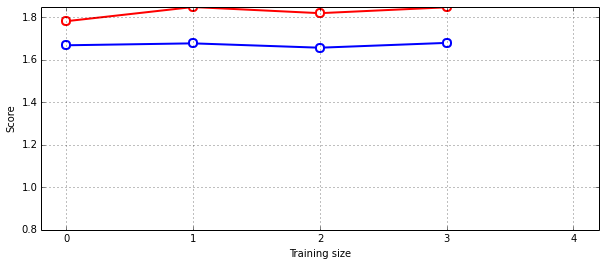

In [3]:
print "Original:", originals
print "Sampled:", samples

from graphlearn.utils.draw import plot_charts
plot_charts(originals, data2=samples, xlabel="Training size", ylabel="Score", size=(10,4), log_scale=False)